# Inside unsupervised learning: Group segmentation using clustering
## Build systems to segment users into distinct and homogenous groups
### by Ankur A. Patel + O'Reilly Media, Inc.

## Overview - Part A
In this notebook, you will understand how to:
#1 Perform good feature engineering
#2 Cluster users into distinct and homogenous groups
#3 Efficiently label a dataset after clustering, turning an unsupervised problem into a semi-supervised one

Specifically, we will perform feature engineering and cluster borrowers into distinct groups using the clustering algorithms we introduce.

## Data Preparation
Let's load in the MNIST dataset.

In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time, pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algorithms'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

In [4]:
# Load the datasets
os.chdir('..')

#os.chdir('/home/jovyan/')
current_path = os.getcwd()
file = '/data/mnist_data/mnist.pkl.gz'

f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [5]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train), \
                         len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

## Principal Component Analysis
To make it easier for the clustering algorithms to find underlying patterns in the data, let us first perform PCA on the MNIST dataset.

In [6]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

## Clustering Algorithm 1 - K-means


In [7]:
# K-means - Inertia as the number of clusters varies
from sklearn.cluster import KMeans

n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=range(2,21), \
                              columns=['inertia'])
for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state, \
                n_jobs=n_jobs)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

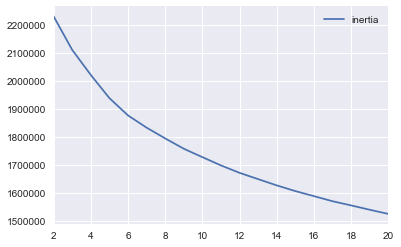

In [8]:
kMeans_inertia.plot()

In [9]:
# Define function to analyze the homogeneity of the clusters

def analyzeCluster(clusterDF, labelsDF):
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = \
        pd.DataFrame(data=preds.groupby('cluster').agg( \
                        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
                        left_on="cluster",right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
                        accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
                        accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, \
            accuracyDF, overallAccuracy, accuracyByLabel

In [10]:
# K-means - Accuracy as the number of clusters varies

n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = \
    pd.DataFrame(data=[],index=range(2,21),columns=['inertia'])
overallAccuracy_kMeansDF = \
    pd.DataFrame(data=[],index=range(2,21),columns=['overallAccuracy'])

for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state, \
                n_jobs=n_jobs)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = \
        pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, \
                     columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

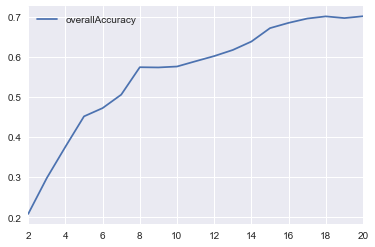

In [11]:
overallAccuracy_kMeansDF.plot()

In [12]:
# Some clusters are more homogenous than others
accuracyByLabel_kMeans

0     0.636506
1     0.928505
2     0.848714
3     0.521805
4     0.714337
5     0.950980
6     0.893103
7     0.919040
8     0.404707
9     0.500522
10    0.381526
11    0.587680
12    0.463382
13    0.958046
14    0.870888
15    0.942325
16    0.791192
17    0.843972
18    0.455679
19    0.926480
dtype: float64

In [13]:
# K-means - Accuracy as the number of components varies, for n-clusters = 20

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 784],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 784], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 784]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state, \
                n_jobs=n_jobs)

    cutoff = cutoffNumber
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

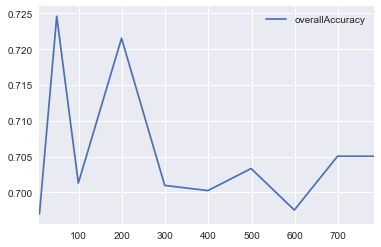

In [14]:
overallAccuracy_kMeansDF.plot()

In [15]:
# K-means - Accuracy as the number of components varies
# On the original MNIST data (not PCA-reduced)

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 784],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 784], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 784]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state, \
                n_jobs=n_jobs)

    cutoff = cutoffNumber
    kmeans.fit(X_train.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

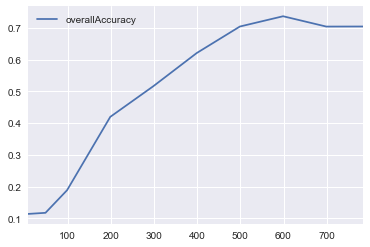

In [16]:
overallAccuracy_kMeansDF.plot()

## Clustering Algorithm 2 - Hierarchical clustering

In [17]:
# Hierarchical clustering

In [18]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist

cutoff = 99
Z = fastcluster.linkage_vector(X_train_PCA.loc[:,0:cutoff], \
                               method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z, \
    columns=['clusterOne','clusterTwo','distance','newClusterSize'])

In [19]:
Z_dataFrame.iloc[:20]

,clusterOne,clusterTwo,distance,newClusterSize
0,42194.0,43025.0,0.562682,2.0
1,28350.0,37674.0,0.590866,2.0
2,26696.0,44705.0,0.621506,2.0
3,12634.0,32823.0,0.627762,2.0
4,24707.0,43151.0,0.637668,2.0
5,20465.0,24483.0,0.662557,2.0
6,466.0,42098.0,0.664189,2.0
7,46542.0,49961.0,0.665520,2.0
8,2301.0,5732.0,0.671215,2.0
9,37564.0,47668.0,0.675121,2.0


In [20]:
Z_dataFrame.iloc[49980:]

,clusterOne,clusterTwo,distance,newClusterSize
49980,99965.0,99972.0,161.106998,5197.0
49981,99932.0,99980.0,172.070003,6505.0
49982,99945.0,99960.0,182.840860,3245.0
49983,99964.0,99976.0,184.475761,3683.0
49984,99974.0,99979.0,185.027847,7744.0
49985,99940.0,99975.0,185.345207,5596.0
49986,99957.0,99967.0,211.854714,5957.0
49987,99938.0,99983.0,215.494857,4846.0
49988,99978.0,99984.0,216.760365,11072.0
49989,99970.0,99973.0,217.355871,4899.0


In [21]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 160
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = \
    pd.DataFrame(data=clusters,index=X_train_PCA.index,columns=['cluster'])

In [22]:
print("Number of distinct clusters: ", \
      len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  20


In [23]:
countByCluster_hierClust, countByLabel_hierClust, \
    countMostFreq_hierClust, accuracyDF_hierClust, \
    overallAccuracy_hierClust, accuracyByLabel_hierClust \
    = analyzeCluster(X_train_hierClustered, y_train)

print("Overall accuracy from hierarchical clustering: ", \
      overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.76882


In [24]:
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0     0.987962
1     0.983727
2     0.988998
3     0.597356
4     0.678642
5     0.442478
6     0.950033
7     0.829060
8     0.976062
9     0.986141
10    0.990183
11    0.992183
12    0.971033
13    0.554273
14    0.553617
15    0.720183
16    0.538891
17    0.484590
18    0.957732
19    0.977310
dtype: float64

## Clustering Algorithm 3 - DBSCAN

In [25]:
# DBSCAN

In [26]:
from sklearn.cluster import DBSCAN

eps = 3
min_samples = 5
leaf_size = 30
n_jobs = 4

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
            n_jobs=n_jobs)

cutoff = 99
X_train_PCA_dbscanClustered = db.fit_predict(X_train_PCA.loc[:,0:cutoff])
X_train_PCA_dbscanClustered = \
    pd.DataFrame(data=X_train_PCA_dbscanClustered, index=X_train.index, \
                 columns=['cluster'])

countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, \
    accuracyDF_dbscan, overallAccuracy_dbscan, accuracyByLabel_dbscan \
    = analyzeCluster(X_train_PCA_dbscanClustered, y_train)

overallAccuracy_dbscan

0.242

In [27]:
print("Overall accuracy from DBSCAN: ",overallAccuracy_dbscan)

Overall accuracy from DBSCAN:  0.242


In [28]:
print("Cluster results for DBSCAN")
countByCluster_dbscan

Cluster results for DBSCAN


,cluster,clusterCount
0,-1,39575
1,0,8885
2,8,720
3,5,92
4,18,51
5,38,38
6,41,22
7,39,22
8,4,16
9,20,16


## Clustering Algorithm 4 - Hierarchical DSCAN

In [29]:
# HDBSCAN

In [30]:
import hdbscan

min_cluster_size = 30
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
        min_samples=min_samples, alpha=alpha, \
        cluster_selection_method=cluster_selection_method)

cutoff = 10
X_train_PCA_hdbscanClustered = \
    hdb.fit_predict(X_train_PCA.loc[:,0:cutoff])

X_train_PCA_hdbscanClustered = \
    pd.DataFrame(data=X_train_PCA_hdbscanClustered, \
    index=X_train.index, columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
    countMostFreq_hdbscan, accuracyDF_hdbscan, \
    overallAccuracy_hdbscan, accuracyByLabel_hdbscan \
    = analyzeCluster(X_train_PCA_hdbscanClustered, y_train)

In [31]:
print("Overall accuracy from HDBSCAN: ",overallAccuracy_hdbscan)

Overall accuracy from HDBSCAN:  0.24696


In [32]:
print("Cluster results for HDBSCAN")
countByCluster_hdbscan

Cluster results for HDBSCAN


,cluster,clusterCount
0,-1,42570
1,4,5140
2,7,942
3,0,605
4,6,295
5,3,252
6,1,119
7,5,45
8,2,32


## Exercises
Perform K-means, hierarchical clustering, DBSCAN, and HDBSCAN on the MNIST test set and compare accuracies.
Remember to perform PCA first.

### K-Means
Use 20 clusters but all 784 PCA components.

In [ ]:
# PCA
X_test_PCA = pca.fit_transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=test_index)

# K-means
n_clusters = #Fill in
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state, \
                n_jobs=n_jobs)

kmeans.fit(#Fill in)
X_test_kmeansClustered = kmeans.predict(#Fill in)
X_test_kmeansClustered = pd.DataFrame(data=X_test_kmeansClustered, \
                            index=X_test.index, columns=['cluster'])

countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
    accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
    = analyzeCluster(X_test_kmeansClustered, y_test)

print("Overall accuracy from K-means: ", \
      overallAccuracy_kMeans)

### Hierarchical clustering
Use 100 PCA components and a distance threshold of 140.

In [ ]:
# Hierarchical Clustering
cutoff = #Fill in
Z = fastcluster.linkage_vector(X_test_PCA.loc[:,0:cutoff], \
                               method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z, \
    columns=['clusterOne','clusterTwo','distance','newClusterSize'])
    
distance_threshold = #Fill in
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_test_hierClustered = \
    pd.DataFrame(data=clusters,index=X_test_PCA.index,columns=['cluster'])
    
countByCluster_hierClust, countByLabel_hierClust, \
    countMostFreq_hierClust, accuracyDF_hierClust, \
    overallAccuracy_hierClust, accuracyByLabel_hierClust \
    = analyzeCluster(X_test_hierClustered, y_test)

print("Overall accuracy from hierarchical clustering: ", \
      overallAccuracy_hierClust)

### DBSCAN
Use 100 PCA compomnents, a distance threshold of 3 ("eps") and a minimum number of samples of 5.

In [ ]:
# DBSCAN
from sklearn.cluster import DBSCAN

eps = #Fill in
min_samples = #Fill in
leaf_size = 30
n_jobs = 4

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
            n_jobs=n_jobs)

cutoff = #Fill in
X_test_PCA_dbscanClustered = db.fit_predict(X_test_PCA.loc[:,0:cutoff])
X_test_PCA_dbscanClustered = \
    pd.DataFrame(data=X_test_PCA_dbscanClustered, index=X_test.index, \
                 columns=['cluster'])

countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, \
    accuracyDF_dbscan, overallAccuracy_dbscan, accuracyByLabel_dbscan \
    = analyzeCluster(X_test_PCA_dbscanClustered, y_test)
    
print("Overall accuracy from DBSCAN: ", \
      overallAccuracy_dbscan)

### HDBSCAN
Use 10 PCA components, a min_cluster_sample of 25, and an alpha of 1.0.

In [ ]:
# HDBSCAN
import hdbscan

min_cluster_size = #Fill in
min_samples = None
alpha = #Fill in
cluster_selection_method = 'eom'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
        min_samples=min_samples, alpha=alpha, \
        cluster_selection_method=cluster_selection_method)

cutoff = #Fill in
X_test_PCA_hdbscanClustered = \
    hdb.fit_predict(X_test_PCA.loc[:,0:cutoff])

X_test_PCA_hdbscanClustered = \
    pd.DataFrame(data=X_test_PCA_hdbscanClustered, \
    index=X_test.index, columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
    countMostFreq_hdbscan, accuracyDF_hdbscan, \
    overallAccuracy_hdbscan, accuracyByLabel_hdbscan \
    = analyzeCluster(X_test_PCA_hdbscanClustered, y_test)
    
print("Overall accuracy from HDBSCAN: ", \
      overallAccuracy_hdbscan)  

## Answers to the Exercises

In [44]:
# PCA
X_test_PCA = pca.fit_transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=test_index)

# K-means
n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state, \
                n_jobs=n_jobs)

kmeans.fit(X_test_PCA)
X_test_kmeansClustered = kmeans.predict(X_test_PCA)
X_test_kmeansClustered = pd.DataFrame(data=X_test_kmeansClustered, \
                            index=X_test.index, columns=['cluster'])

countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
    accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
    = analyzeCluster(X_test_kmeansClustered, y_test)

print("Overall accuracy from K-means: ", \
      overallAccuracy_kMeans)
    
# Hierarchical Clustering
cutoff = 99
Z = fastcluster.linkage_vector(X_test_PCA.loc[:,0:cutoff], \
                               method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z, \
    columns=['clusterOne','clusterTwo','distance','newClusterSize'])
    
distance_threshold = 140
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_test_hierClustered = \
    pd.DataFrame(data=clusters,index=X_test_PCA.index,columns=['cluster'])
    
countByCluster_hierClust, countByLabel_hierClust, \
    countMostFreq_hierClust, accuracyDF_hierClust, \
    overallAccuracy_hierClust, accuracyByLabel_hierClust \
    = analyzeCluster(X_test_hierClustered, y_test)

print("Overall accuracy from hierarchical clustering: ", \
      overallAccuracy_hierClust)
    

# DBSCAN
from sklearn.cluster import DBSCAN

eps = 3
min_samples = 5
leaf_size = 30
n_jobs = 4

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
            n_jobs=n_jobs)

cutoff = 99
X_test_PCA_dbscanClustered = db.fit_predict(X_test_PCA.loc[:,0:cutoff])
X_test_PCA_dbscanClustered = \
    pd.DataFrame(data=X_test_PCA_dbscanClustered, index=X_test.index, \
                 columns=['cluster'])

countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, \
    accuracyDF_dbscan, overallAccuracy_dbscan, accuracyByLabel_dbscan \
    = analyzeCluster(X_test_PCA_dbscanClustered, y_test)
    
print("Overall accuracy from DBSCAN: ", \
      overallAccuracy_dbscan)

# HDBSCAN
import hdbscan

min_cluster_size = 25
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
        min_samples=min_samples, alpha=alpha, \
        cluster_selection_method=cluster_selection_method)

cutoff = 10
X_test_PCA_hdbscanClustered = \
    hdb.fit_predict(X_test_PCA.loc[:,0:cutoff])

X_test_PCA_hdbscanClustered = \
    pd.DataFrame(data=X_test_PCA_hdbscanClustered, \
    index=X_test.index, columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
    countMostFreq_hdbscan, accuracyDF_hdbscan, \
    overallAccuracy_hdbscan, accuracyByLabel_hdbscan \
    = analyzeCluster(X_test_PCA_hdbscanClustered, y_test)
    
print("Overall accuracy from HDBSCAN: ", \
      overallAccuracy_hdbscan)   

Overall accuracy from K-means:  0.7024
Overall accuracy from hierarchical clustering:  0.4978
Overall accuracy from DBSCAN:  0.2357
Overall accuracy from HDBSCAN:  0.2466


## Conclusion to Part A
In this notebook, we explored and applied clustering algorithms on the MNIST dataset.
In the next notebook, we will apply clustering methods to a real world dataset of loan borrowers and use clustering to segment the users into distinct and homogenous groups based on creditworthiness.
Group segementation is one real world application of clustering.